In [29]:
!pip install einops
!pip install yfinance

In [30]:
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import torch

import yfinance as yf
import pandas as pd
import numpy as np
import os

from torch.utils.data import DataLoader, Subset, RandomSampler, Dataset
from torch.nn import MSELoss
from torch.optim import RMSprop
from torch.optim.lr_scheduler import ExponentialLR

# Définition du dataset

In [31]:
from typing import Tuple

class RLDataset(Dataset):
    def __init__(self, start_date: str="jj-mm-aaaa", end_date: str="jj-mm-aaaa", 
                 interval: str='1d', episode_size: int=150, nb_states : int = 30, normalize: bool=True,
                 file_dir: str="data/", csv_file: str=None):
      
        self.episode_size = episode_size
        self.normalize = normalize
        self.nb_states = nb_states

        if csv_file is not None: # If a local data file must be loaded:
            self.root_dir = file_dir
            self.filename = csv_file
            with open(os.path.join(file_dir,csv_file), 'r') as file:
                data = pd.read_csv(file, sep=',', header='infer')
        else: # Data must be loaded on an online database:
            data = yf.download('^GSPC', start=start_date, end=end_date, interval=interval)
        
        self.data = data
        seq_init = data['Close'].tolist()
        if self.normalize :
            seq = [seq_init[i]/seq_init[i-1] -1 for i in range(1, len(seq_init))]

        # split into items of size nb_samples
        X = np.array(seq)
        X_ref = np.array(seq_init[1:])
        X_ref = X_ref / X_ref[0]

        self.X = X
        self.X_ref = X_ref


    def __len__(self) -> int:
        return len(self.X)-(self.nb_states+self.episode_size+1)


    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        X_ep = np.array([self.X[i:i+self.nb_states] for i in range(index, index+self.episode_size)])
        X_val = self.X_ref[index+self.nb_states:index+self.nb_states+self.episode_size]
        Y_val = self.X_ref[index+self.nb_states+1:index+self.nb_states+1+self.episode_size]
        return (X_ep,X_val), Y_val

    def get_input_output(self):
      return self.X, self.Y
      

    def get_normalization_value(self, index):
        # Retrieve the normalization value from the last sample
        return self.norm_val[index]

In [32]:
from torch.nn import Linear, ModuleList, Module, Sequential, Dropout, ReLU

# Définition du réseau :
Ce réseau permet de mettre en place la policy de l'agent en d'approchant la fonction $Q:(s,a) → Q(s,a)$

In [33]:
class DQN(Module):
    def __init__(self, input_size = 31, hidden_size = 50 , num_layers = 10, drop_out = 0.1, output_size = 20) -> None:
        super().__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size 
        self.num_layers = num_layers
        self.output_size = output_size
        self.first_layer = Linear(self.input_size, self.hidden_size)
        self.mlp = ModuleList(
            [Sequential(
                Linear(self.hidden_size,self.hidden_size),
                ReLU(),
                Dropout(drop_out)
            ) for _ in range(self.num_layers)]
        )
        self.head = Linear(self.hidden_size,output_size)

    def forward(self,x):
      tmp = self.first_layer.forward(x)
      for i in range(self.num_layers):
        tmp = self.mlp[i].forward(tmp)
      y = self.head.forward(tmp)
      return y

# Fonction outil 
Permet de créer les batchs du dataset une fois l'épisode terminé

In [34]:
import random as rd

In [35]:
def create_batch_index(nb_samples, batch_size):
  ind = [i for i in range(nb_samples)]
  batch_list = list()
  while len(ind)>batch_size:
    batch = list()
    for _ in range(batch_size):
      i = rd.randint(0, len(ind)-1)
      x = ind.pop(i)
      batch.append(x)
    batch_list.append(batch)
  return batch_list

In [36]:
from torch.nn import MSELoss

# Définition de l'agent utilisant le DQN

In [37]:
class DQNAgent:
  def __init__(self, v=1, q = 0, m = 100, nb_actions = 20, network = DQN(), eps = 1, eps_decay = 0.95, min_eps = 0.1, gamma = 0.01,
               batch_size = 16, lr = 1e-03) -> None:
      self.eps = eps 
      self.eps_decay = eps_decay
      self.min_eps = min_eps
      self.gamma = gamma

      self.q = q
      self.m = m
      self.nb_actions = nb_actions
      
      self.current_v = v
      self.current_score = self.m
  
      self.net = network
      self.lr = lr
      self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
      self.loss_fn = MSELoss()

      self.batch_size = batch_size
      
      self.use_cuda = torch.cuda.is_available()
      if self.use_cuda:
           device="cuda"
      else :
          device = "cpu"
      self.device = device

      self.net.to(device)
      self.reward_list = list()

  def reset(self, v, q, m):
      self.current_v = v
      self.q = q
      self.m = m

  def policy(self, state):
      if rd.random() < self.eps :
        return torch.tensor(rd.randint(0, self.nb_actions - 1))
      else :
        return torch.argmax(self.net.forward(state))

  def act(self, state, action):
      max_q = self.q+self.m/self.current_v
      new_q = action.item()/(self.nb_actions-1)*max_q
      self.m += (self.q-new_q)*self.current_v
      self.q = new_q

  def compute_reward(self, new_v):
      self.current_v = new_v
      new_score = self.m + self.q*self.current_v
      r = new_score - self.current_score
      self.current_score = new_score
      self.reward_list.append(r)
      return r

  def decrease_eps(self):
    tmp = self.eps*self.eps_decay
    if tmp > self.min_eps :
      self.eps = tmp

  def train_model(self, states, actions, rewards):
    states = torch.tensor(states).to(self.device).float()
    with torch.no_grad():
      # We need to compute the targets 
      target = self.net(states)
      target = torch.max(target, 1)[0]
      target = torch.tensor(rewards).to(self.device)[:-1] + torch.tensor(self.gamma).to(self.device)*target[1:]
    batch_indexes = create_batch_index(len(target), self.batch_size)
    tmp_actions = torch.tensor(actions)

    tot_loss = 0

    for batch in batch_indexes :
      batch_states = states[batch]
      batch_target = target[batch].float()
      batch_mask = torch.zeros((self.batch_size,self.nb_actions))
      for i, ind in enumerate(batch):
        batch_mask[i,tmp_actions[ind]] = 1
      batch_mask = batch_mask.to(self.device).float()
      pred = self.net(batch_states)
      pred = torch.sum(torch.mul(pred, batch_mask), 1)

      loss = self.loss_fn(pred, batch_target)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      tot_loss += loss.item()
    return tot_loss


# Définition d'un agent prenant des décisions aléatoirement 
Permet la comparaision avec notre agent utilisant du RL

In [38]:
class RandomAgent:
  def __init__(self, v=1, q = 0, m = 100) -> None:

      self.q = q
      self.m = m
      self.current_v = v
      self.current_score = self.m

  def reset(self, v, q, m):
      self.current_v = v
      self.q = q
      self.m = m

  def act(self):
      q_max = self.q + self.m/self.current_v
      new_q = rd.random()*q_max
      self.m += (self.q-new_q)*self.current_v
      self.q = new_q

  def compute_reward(self, new_v):
      self.current_v = new_v
      new_score = self.m + self.q*self.current_v
      r = new_score - self.current_score
      self.current_score = new_score
      return r


# Entrainement

[*********************100%***********************]  1 of 1 completed
Current episode : 199, on : 200

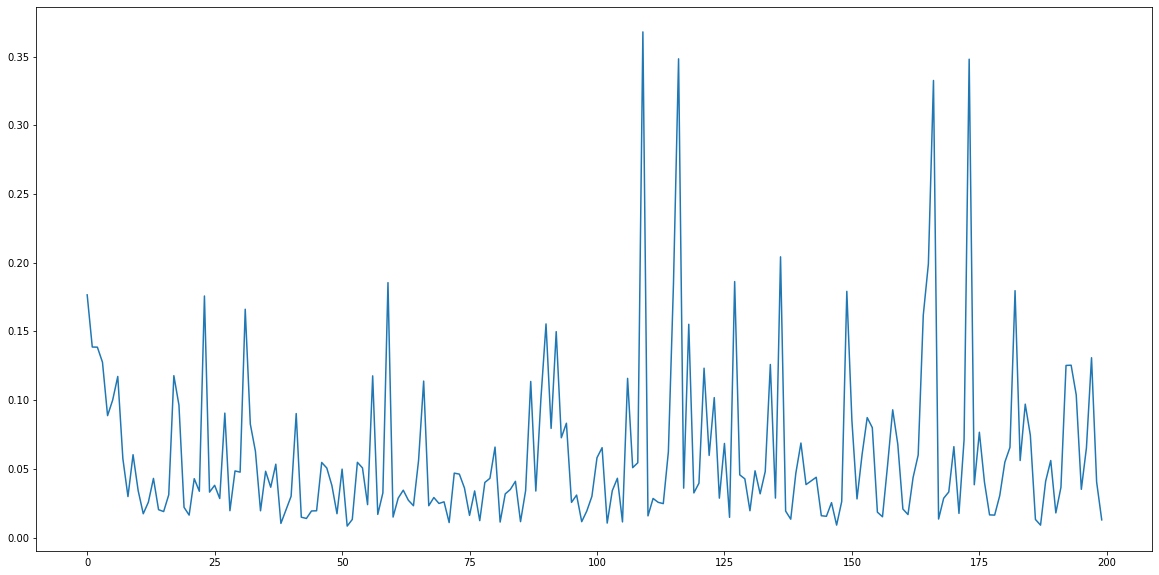

In [39]:
EPISODE_SIZE = 150
STATE_SIZE = 30

NB_ACTIONS = 8

NB_EPISODE = 200

q = 0
m = 10

loss_list = list()

if torch.cuda.is_available():
    device = device="cuda"
else :
    device = "cpu"

dataset = RLDataset(start_date = "1960-01-01", end_date="2000-01-01",episode_size = EPISODE_SIZE , nb_states = STATE_SIZE)
n = len(dataset)

net = DQN(input_size = STATE_SIZE + 1, output_size = NB_ACTIONS, hidden_size=20, num_layers=5)

agent = DQNAgent(q = q, m = m, nb_actions = NB_ACTIONS, network = net, gamma = 0.1)


for ep in range(NB_EPISODE):
    print("\rCurrent episode : {}, on : {}".format(ep,NB_EPISODE), end = "")
    p = rd.randint(0,n-1)
    X, Y = dataset[p]
    X_ev, X_ref = X
    X = np.hstack((X_ev,X_ref[:,np.newaxis]))

    agent.reset(X_ref[0], q, m)
    action_list = list()
    reward_list = list()
    with torch.no_grad():
      for t in range(EPISODE_SIZE):
        state = torch.tensor(X[t]).to(device).float()
        action = agent.policy(state)
        agent.act(state, action)
        reward = agent.compute_reward(Y[t])

        action_list.append(action)
        reward_list.append(reward)

    loss = agent.train_model(X, action_list, reward_list)
    loss_list.append(loss)
    if (ep+1)%20 == 0:
      agent.decrease_eps()

plt.plot(loss_list)
      


# Test
On compare l'efficacité de notre agent avec un agent aléatoire.

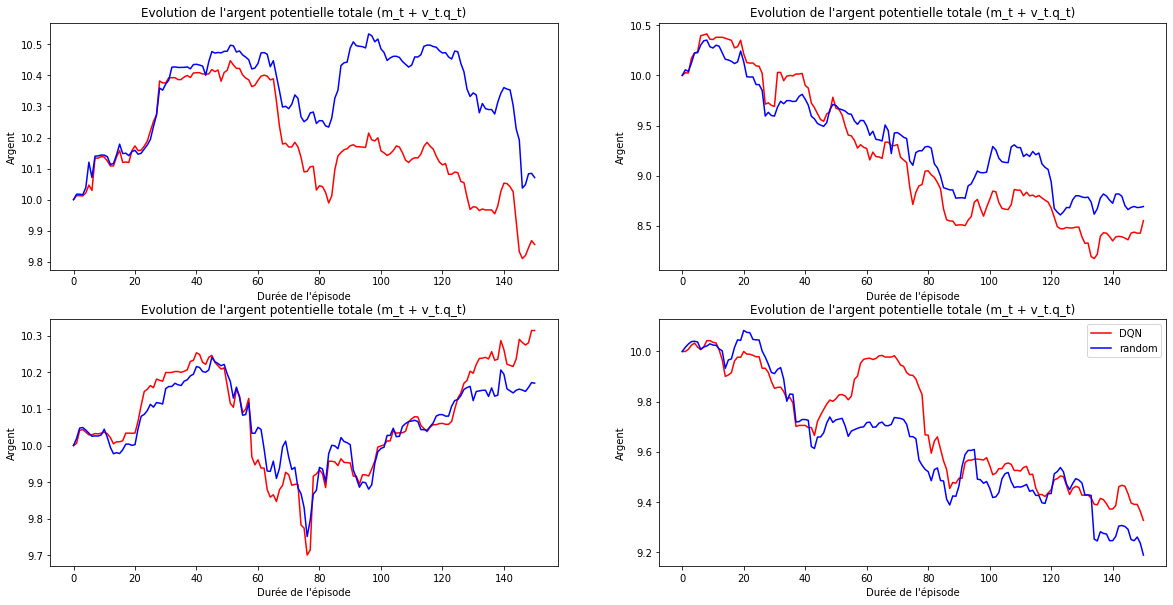

-0.018524652282662757


In [41]:
nb_ep_test = 4
is_better = 0
plt.rcParams["figure.figsize"] = (20,10)

fig, axs = plt.subplots(2, 2)
for i in range(nb_ep_test):
  p = rd.randint(0,n-1)
  X, Y = dataset[p]
  X_ev, X_ref = X
  X = np.hstack((X_ev,X_ref[:,np.newaxis]))

  rd_agent=RandomAgent(X_ref[0],q,m)

  agent.reset(X_ref[0], q, m)


  #action_list = list()
  #reward_list = list()
  q_list = [q]
  #m_list = [m]
  score_list = [m]
  rd_score = [m]

  with torch.no_grad():
    for t in range(EPISODE_SIZE):
      state = torch.tensor(X[t]).to(device).float()
      action = agent.policy(state)
      agent.act(state, action)
      reward = agent.compute_reward(Y[t])

      rd_agent.act()
      _ = rd_agent.compute_reward(Y[t])

      #action_list.append(action)
      #reward_list.append(reward)
      q_list.append(agent.q)
      #m_list.append(agent.m)
      score_list.append(agent.current_score)
      
      rd_score.append(rd_agent.current_score)
    is_better += agent.current_score - rd_agent.current_score

  
  axs[i%2, i//2].plot(score_list, 'r', label = "DQN")
  axs[i%2, i//2].plot(rd_score, 'b', label = "random")
  axs[i%2, i//2].set_title("Evolution de l'argent potentielle totale (m_t + v_t.q_t)")

plt.legend()  

for ax in axs.flat:
    ax.set(xlabel="Durée de l'épisode", ylabel="Argent")

plt.show()
print(is_better/nb_ep_test)

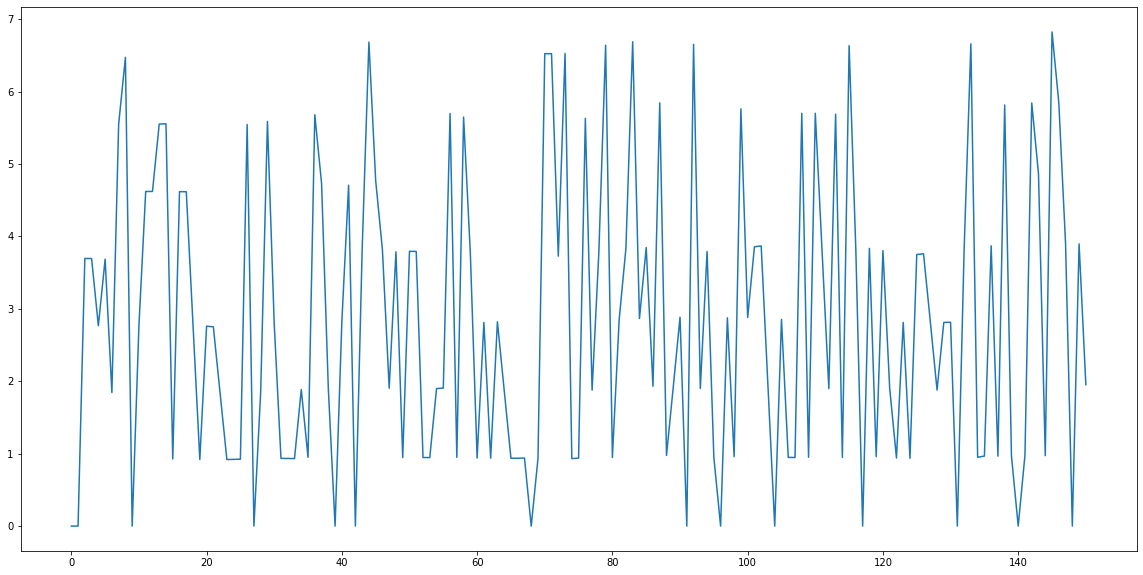

In [42]:
plt.plot(q_list)